In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from nn_utils import *

import logging
tf.get_logger().setLevel(logging.ERROR)
tf.enable_eager_execution()

%matplotlib inline

In [2]:
class NeuralNetwork:
    
    def __init__(self, layers):
        
        self.layers = layers
        self.num_layers = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}
        self.b = {}
        
        self.dW = {}
        self.db = {}
        
        self.initialize()
        
        
    def initialize(self):
        
        for i in range(1, self.num_layers):
            self.W[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], self.layers[i - 1])))
            self.b[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], 1)))
            
            
    def forward_pass(self, X):
        
        A = tf.convert_to_tensor(X, dtype = tf.float32)
        
        for i in range(1, self.num_layers):
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            if i != self.num_layers - 1:
                A = tf.nn.relu(Z)
            else:
                A = Z
            
        return A
    
    
    def compute_loss(self, A, Y):
        
        loss = tf.nn.softmax_cross_entropy_with_logits(logits = A, labels = Y)
        
        return tf.reduce_mean(loss)
    
    
    def update_params(self, lr):
        
        for i in range(1, self.num_layers):
            self.W[i].assign_sub(lr * self.dW[i])
            self.b[i].assign_sub(lr * self.db[i])
            
            
    def predict(self, X):
        
        A = self.forward_pass(X)
        
        return tf.argmax(tf.nn.softmax(A), axis = 1)
    
    
    def info(self):
        
        num_params = 0
        
        for i in range(1, self.num_layers):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        
        print('Input features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        
        for i in range(1, self.num_layers - 1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        
        print('---------------')
        print('Number of parameters:', num_params)
        
        
    def train_on_batch(self, X, Y, lr):
        
        X = tf.convert_to_tensor(X, dtype = tf.float32)
        Y = tf.convert_to_tensor(Y, dtype = tf.float32)
        
        with tf.GradientTape(persistent = True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
            
        for i in range(1, self.num_layers):
            self.dW[i] = tape.gradient(loss, self.W[i])
            self.db[i] = tape.gradient(loss, self.b[i])
            
        del tape
        
        self.update_params(lr)
        
        return loss.numpy()
    
    
    def train(self, X_train, Y_train, X_test, Y_test, epochs, steps_per_epoch, batch_size, lr):
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        
        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {}'.format(e + 1), end = '.')
            
            for i in range(0, steps_per_epoch):
                X_batch = X_train[i * batch_size: (i + 1) * batch_size]
                Y_batch = Y_train[i * batch_size: (i + 1) * batch_size]
                
                batch_loss = self.train_on_batch(X_batch, Y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i % int(steps_per_epoch / 10) == 0:
                    print(end = '.')
                    
            history['train_loss'].append(epoch_train_loss / steps_per_epoch)
            
            val_A = self.forward_pass(X_test)
            val_loss = self.compute_loss(val_A, Y_test).numpy()
            history['val_loss'].append(val_loss)
            
            val_preds = self.predict(X_test)
            val_acc = np.mean(np.argmax(Y_test, axis = 1) == val_preds.numpy())
            history['val_acc'].append(val_acc)
            
            print('Val Acc:', val_acc)
        
        return history

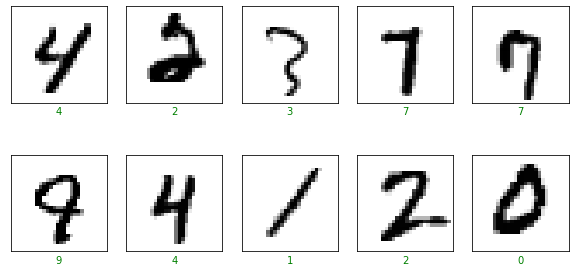

In [3]:
(X_train, Y_train), (X_test, Y_test) = load_data()
plot_random_examples(X_train, Y_train).show()

In [4]:
model = NeuralNetwork([784, 128, 128, 10])
model.info()

Input features: 784
Number of Classes: 10
Hidden Layers:
Layer 1, Units 128
Layer 2, Units 128
---------------
Number of parameters: 118282


In [5]:
batch_size = 120
epochs = 20
steps_per_epoch = int(X_train.shape[0] / batch_size)
lr = 3e-3
print('Steps per epoch:', steps_per_epoch)

Steps per epoch: 500


In [6]:
history = model.train(
    X_train, Y_train, 
    X_test, Y_test, 
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 1...........Val Acc: 0.8219
Epoch 2...........Val Acc: 0.8524
Epoch 3...........Val Acc: 0.8686
Epoch 4...........Val Acc: 0.8767
Epoch 5...........Val Acc: 0.881
Epoch 6...........Val Acc: 0.886
Epoch 7...........Val Acc: 0.8875
Epoch 8...........Val Acc: 0.8906
Epoch 9...........Val Acc: 0.8916
Epoch 10...........Val Acc: 0.8937
Epoch 11...........Val Acc: 0.8952
Epoch 12...........Val Acc: 0.8958
Epoch 13...........Val Acc: 0.8982
Epoch 14...........Val Acc: 0.899
Epoch 15...........Val Acc: 0.9005
Epoch 16...........Val Acc: 0.9013
Epoch 17...........Val Acc: 0.9024
Epoch 18...........Val Acc: 0.9038
Epoch 19...........Val Acc: 0.9052
Epoch 20...........Val Acc: 0.9052


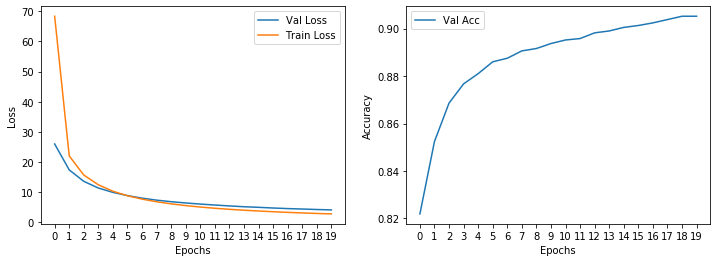

In [7]:
plot_results(history).show()

In [8]:
preds = model.predict(X_test)

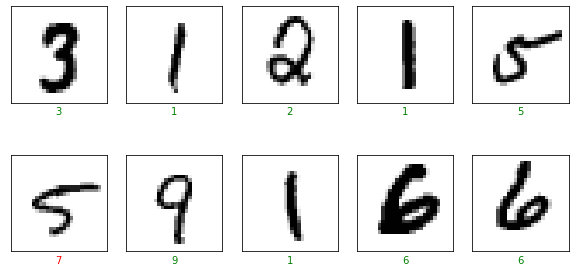

In [10]:
plot_random_examples(X_test, Y_test, preds.numpy()).show()